##  In this notebook we build different kinds of quantum trajectories. We will be primairly interested in:

1. Kerr in qubit regime

2. Kerr in bistable regime

3. Atom bistability (maybe this will be a separate notebook).

We will also be interested in the transition between the first and second regimes of the Kerr system.

I store trajectory files as *.pkl files. This way I can easily load them into another notebook. 

A pickle file will include the parameters (params below), the symbolic expressions for SLH, and the output trajectory as an array of states (real and complex values).

In [43]:
####
####

Regime = "kerr_bistable"

### Select Regime from "kerr_qubit", "kerr_bistable", "intermediate_state"

### TODO: implement a regime "transition_kerr" which increases the drive periodically.

####
####

In [44]:
## QHDL package
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace

## qutip 
import qutip as qt

## numpy
import numpy as np

## plotting
%matplotlib inline
import matplotlib.pyplot as plt

## pickle
import pickle

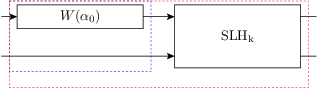

10.0%. Run time:  35.84s. Est. time left: 00:00:05:22
20.0%. Run time:  53.84s. Est. time left: 00:00:03:35
30.0%. Run time:  70.73s. Est. time left: 00:00:02:45
40.0%. Run time:  88.42s. Est. time left: 00:00:02:12
50.0%. Run time: 119.69s. Est. time left: 00:00:01:59
60.0%. Run time: 137.42s. Est. time left: 00:00:01:31
70.0%. Run time: 154.63s. Est. time left: 00:00:01:06
80.0%. Run time: 172.65s. Est. time left: 00:00:00:43
90.0%. Run time: 201.44s. Est. time left: 00:00:00:22
100.0%. Run time: 212.06s. Est. time left: 00:00:00:00
Total run time: 212.16s


In [45]:
# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

if Regime == "kerr_bistable":
    ## bistable regime
    params = {alpha0 : 52.467, chi : -106.066, Delta : 750., kappa_1 : 150., kappa_2 : 0,
              'Ntraj' : 100, 'duration' : 2500., 'Nfock' : 15}
elif Regime == "kerr_qubit":
    ## qubit regime
    params = {alpha0 : 10.0, chi : -100, Delta : 0., kappa_1 : 0.5, kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}
elif Regime == "intermediate_state":
    params = {alpha0 : 100.0, chi : -20.0, Delta : 0, kappa_1 : 1., kappa_2 : 0,
              'Ntraj' : 10, 'duration' : 25000., 'Nfock' : 15}
else:
    raise ValueError("Unknown regime, or not implemented yet.")
    
## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']


# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_num = SYS.substitute(params)

SYS_num.space.dimension = Nfock
psi0 = qt.coherent(Nfock, 0)
Tsim = np.arange(0, duration/1000, 1e-3)

H_num, L_num = SYS_num.HL_to_qutip()
qmc = qt.mcsolve(H_num, psi0, Tsim, L_num, [], ntraj=Ntraj)

In [46]:
SYS

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('k', ''))))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('k', '')))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(alpha_0*sqrt(kappa_1), Create(LocalSpace('k', ''))), ScalarTimesOperator(-sqrt(kappa_1)*conjugate(alpha_0), Destroy(LocalSpace('k', ''))))), ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('k', '')), Create(LocalSpace('k', '')), Destroy(LocalSpace('k', '')), Destroy(LocalSpace('k', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('k', '')), Destroy(LocalSpace('k', ''))))))

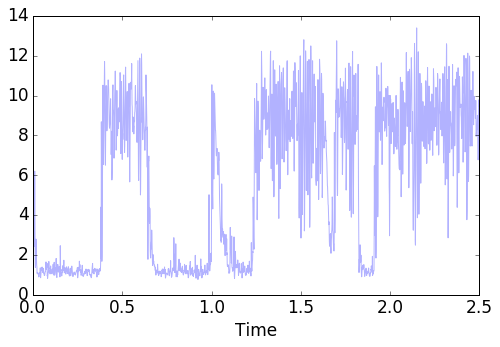

In [47]:
N_num = qt.num(Nfock)

a = qt.destroy(Nfock)
E = a+a.dag()

f, a = plt.subplots(figsize=(8,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

#a.plot(qmc.times, qt.expect(N_num, rho), 'k', linewidth = 2)

for i in range(1): 
    a.plot(qmc.times, qt.expect(N_num, qmc.states[i]), "b", alpha=0.3)

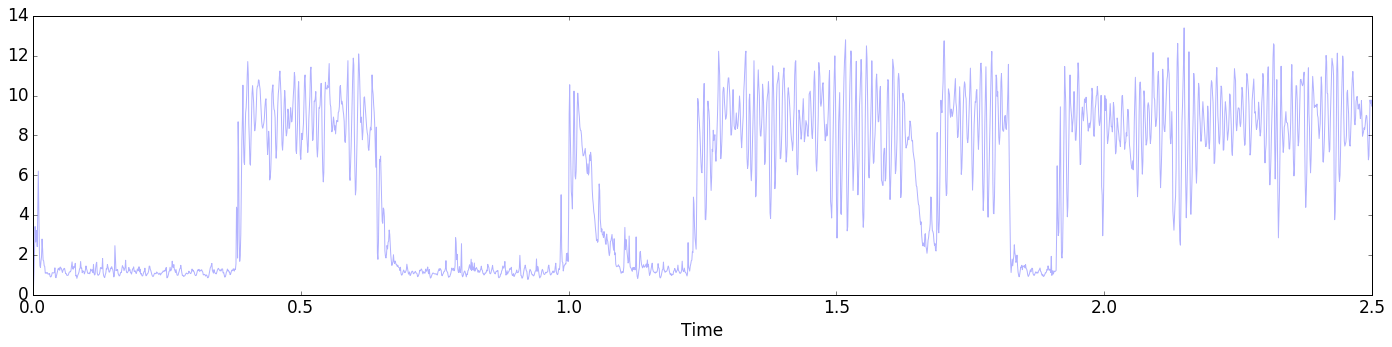

In [48]:
N_num = qt.num(Nfock)

a = qt.destroy(Nfock)
E = a+a.dag()

f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)

#a.plot(qmc.times, qt.expect(N_num, rho), 'k', linewidth = 2)

for i in range(1): 
    a.plot(qmc.times[0:int(duration)], qt.expect(N_num, qmc.states[i])[0:int(duration)], "b", alpha=0.3)

In [49]:

## Take the trajectory data and extract the vectors in the Hilbert space.
## here we double-up the resulting coordiantes, i.e. separate each state into a 
## real and imaginary part.

def make_p_complex():
    p = []
    for traj in qmc.states:
        for k in xrange(0,len(traj)):
            val = np.asarray( traj[k].data.todense().T )[0]
            val_doubled = np.concatenate([val.real,val.imag])
            p.append(val_doubled)
    p = np.asarray(p)
    return p
    
p2=make_p_complex()

In [50]:
## Save the p2 for other notebooks
output = open('./trajectory_data/'+Regime + '.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump((params,SLH,p2), output)

output.close()